# Symulacje

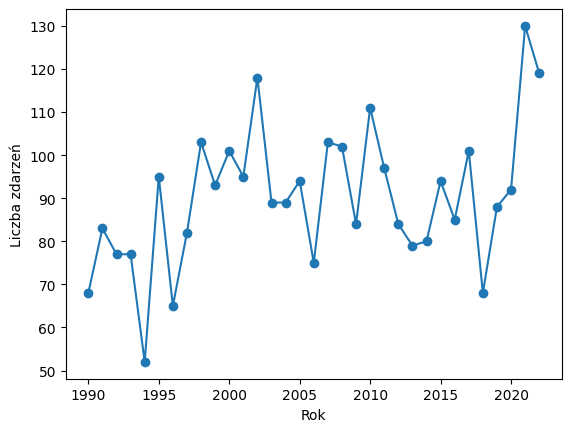

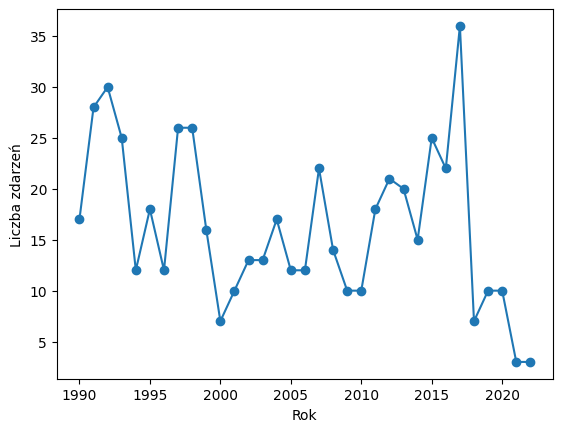

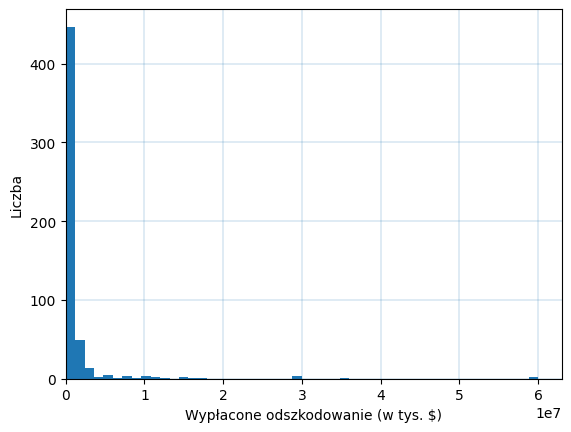

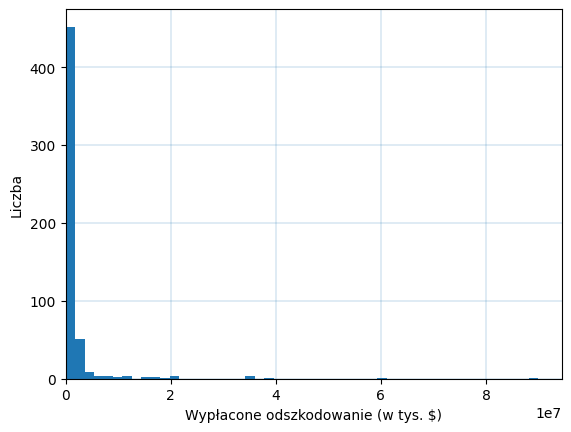

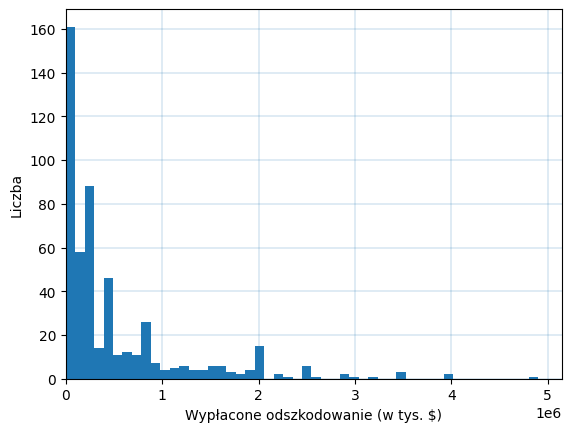

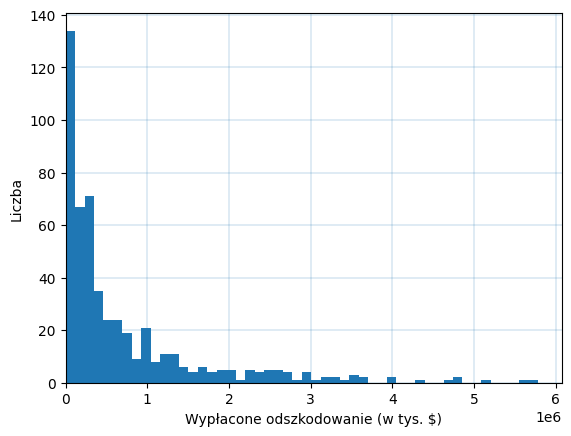

In [11]:
%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\DataPreparation.ipynb"
%run "C:\Users\ndzadz001\Documents\Mgr\Repo\mgr\Modelowanie_liczby_roszczen.ipynb"

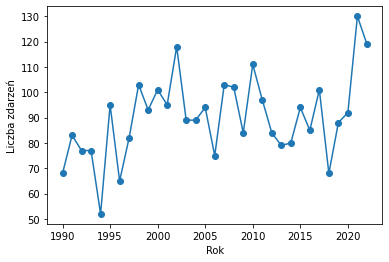

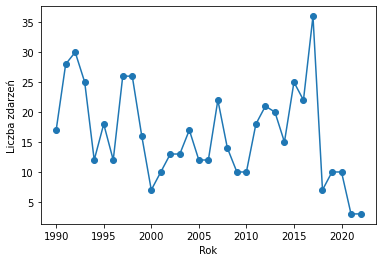

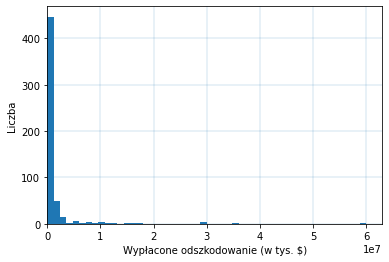

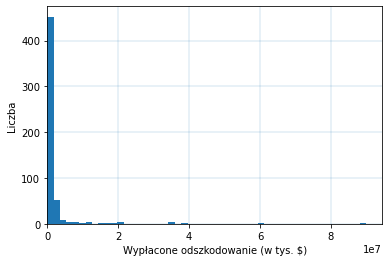

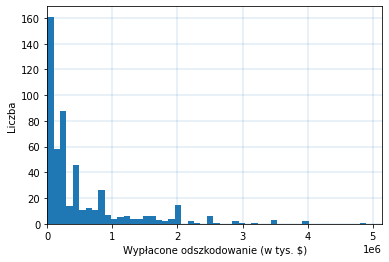

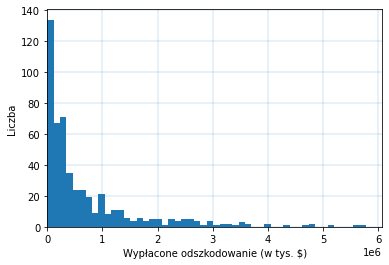

In [62]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_liczby_roszczen.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"
#%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_ryzyka.ipynb"

### Symulacja liczby roszczeń

Empiryczna liczba roszczeń ze zbioru danych

Zbiór treningowy

In [13]:
n = pd.Series(train.groupby('Year').count()['Dis No']) #n jest hard-kodowane w definicjach funkcji sum_of_squares_sin i sum_of_squares_exp
n.index = range(1,len(n)+1)
n

1     17
2     28
3     29
4     25
5     11
6     18
7     12
8     26
9     26
10    16
11     7
12    10
13    13
14    13
15    13
16     9
17    12
18    22
19    13
20    10
21     9
22    16
23    20
Name: Dis No, dtype: int64

In [14]:
N = np.cumsum(n)
N

1      17
2      45
3      74
4      99
5     110
6     128
7     140
8     166
9     192
10    208
11    215
12    225
13    238
14    251
15    264
16    273
17    285
18    307
19    320
20    330
21    339
22    355
23    375
Name: Dis No, dtype: int64

Zbiór testowy

In [15]:
n_test = pd.Series(test.groupby('Year').count()['Dis No']) #n jest hard-kodowane w definicjach funkcji sum_of_squares_sin i sum_of_squares_exp
n_test.index = range(1,len(n_test)+1)
N_test = np.cumsum(n_test)

Sinusoidalna funkcja intensywności

In [16]:
bnds = ((0, None), (0, None), (0, None)) # ograniczenia na wartości parametrów
params = [1.0, 1.0, 1.0] # Przyjmujemy początkowe wartości parametrów
result = minimize(sum_of_squares_sin, params, bounds=bnds, method='L-BFGS-B')
nhpp_pred = nhpp(sin_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
N_pred = np.cumsum(n_pred)
print(result.x)
print(n_pred)

[15.51557519  1.00519821  0.98007143]
Year
2013    18
2014    10
2015     6
2016    15
2017    14
2018    10
2019    15
2020    15
2021    22
2022    14
Name: n, dtype: int64


In [19]:
print("MSE: ", MSE(n_test,n_pred), "MAE: ", MAE(n_test,n_pred))

MSE:  113.1 MAE:  9.3


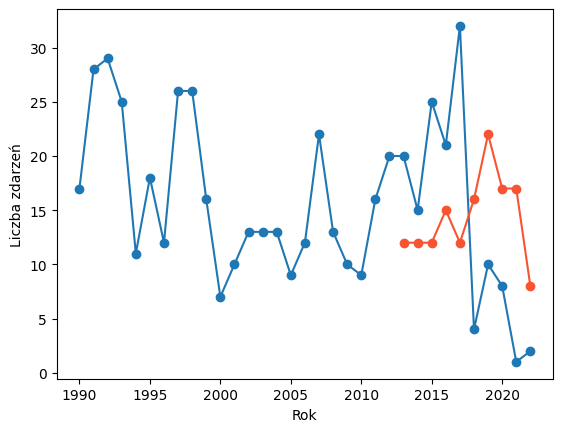

In [20]:
plt.plot(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023)), linestyle= '-',marker='o')
nhpp_pred = nhpp(sin_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
plt.plot(n_pred, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_number_1.pdf")
plt.show()

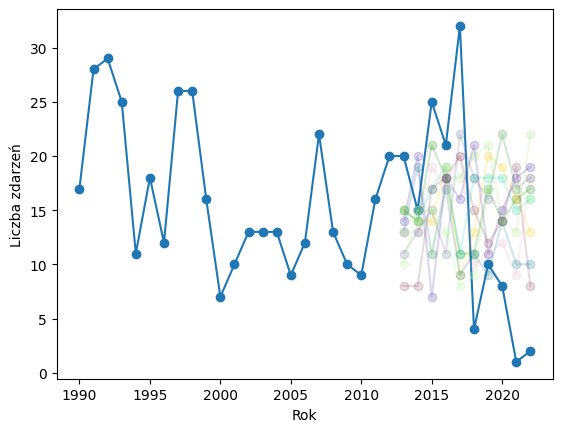

In [21]:
plt.plot(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023)), linestyle= '-',marker='o')
for i in range(10):
    random_color = (random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255,0.2)
    nhpp_pred = nhpp(sin_int_fun,result.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    plt.plot(n_pred, linestyle= '-',marker='o',color=random_color)
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_number_10.pdf")
plt.show()

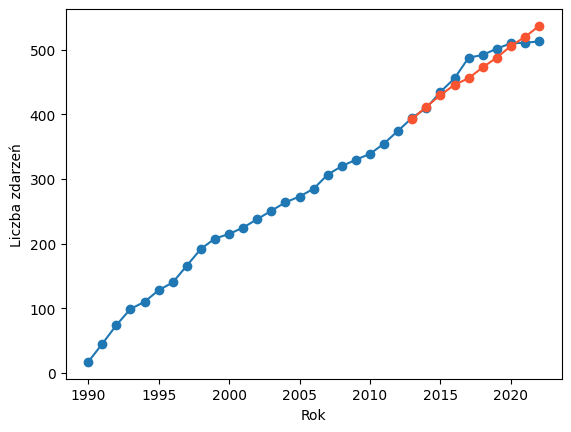

In [22]:
plt.plot(np.cumsum(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023))), linestyle= '-',marker='o')
nhpp_pred = nhpp(sin_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
plt.plot(np.cumsum(n)[23]+np.cumsum(n_pred), linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_cum_number_1.pdf")
plt.show()

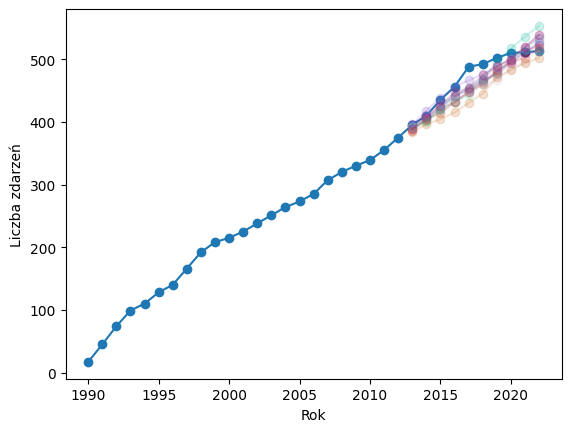

In [23]:
plt.plot(np.cumsum(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023))), linestyle= '-',marker='o')
for i in range(10):
    random_color = (random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255,0.2)
    nhpp_pred = nhpp(sin_int_fun,result.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    plt.plot(np.cumsum(n)[23]+np.cumsum(n_pred), linestyle= '-',marker='o',color=random_color)
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\sin_cum_number_10.pdf")
plt.show()

Funkcja intensywności typu Power Law

Funkcja intensywności Musa-Okumoto

In [29]:
bnds = ((0, None), (0, None)) # ograniczenia na wartości parametrów
params = [1.0, 1.0] # Przyjmujemy początkowe wartości parametrów
result = minimize(sum_of_squares_musa_okumoto, params, bounds=bnds, method='L-BFGS-B')
nhpp_pred = nhpp(musa_okumoto_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
N_pred = np.cumsum(n_pred)
print(result.x)
print(n_pred)

[5.08938892e+02 4.61168818e-02]
Year
2013    23
2014    27
2015    22
2016    15
2017    24
2018    16
2019    20
2020    17
2021    18
2022    18
Name: n, dtype: int64


In [30]:
print("MSE: ", MSE(n_test,n_pred), "MAE: ", MAE(n_test,n_pred))

MSE:  113.2 MAE:  9.6


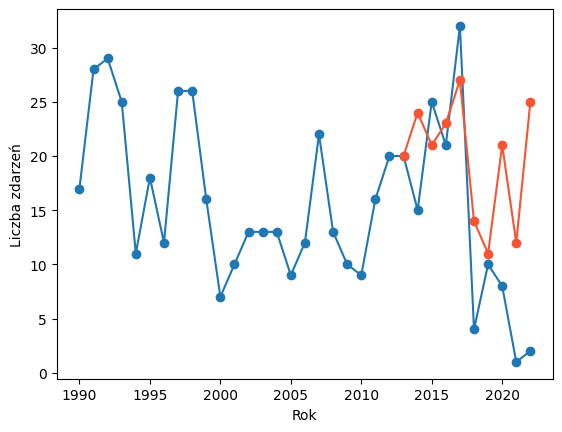

In [35]:
plt.plot(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023)), linestyle= '-',marker='o')
nhpp_pred = nhpp(musa_okumoto_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
plt.plot(n_pred, linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\musa_okumoto_number_1.pdf")
plt.savefig("C:\\Users\\ndzadz001\\Documents\\Mgr\\Repo\\mgr\\Rysunki\\musa_okumoto_number_1.pdf")
plt.show()

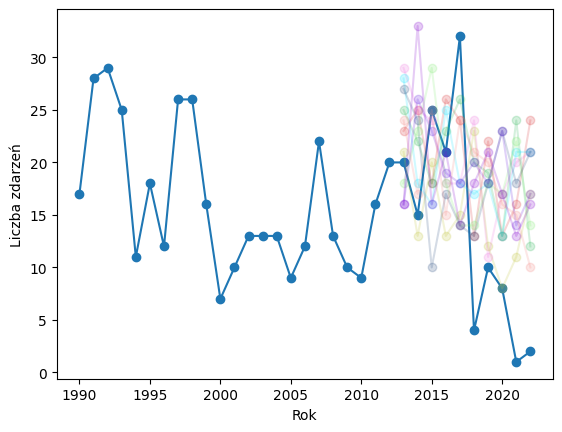

In [36]:
plt.plot(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023)), linestyle= '-',marker='o')
for i in range(10):
    random_color = (random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255,0.2)
    nhpp_pred = nhpp(musa_okumoto_int_fun,result.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    plt.plot(n_pred, linestyle= '-',marker='o',color=random_color)
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\musa_okumoto_number_10.pdf")
plt.savefig("C:\\Users\\ndzadz001\\Documents\\Mgr\\Repo\\mgr\\Rysunki\\musa_okumoto_number_10.pdf")
plt.show()

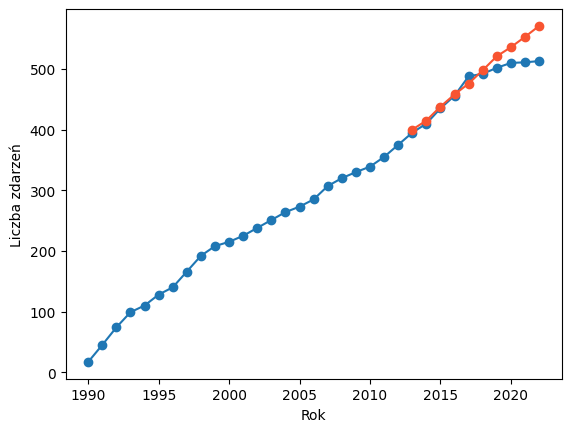

In [37]:
plt.plot(np.cumsum(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023))), linestyle= '-',marker='o')
nhpp_pred = nhpp(musa_okumoto_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
plt.plot(np.cumsum(n)[23]+np.cumsum(n_pred), linestyle= '-',marker='o',color="#f85431")
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\musa_okumoto_cum_number_1.pdf")
plt.savefig("C:\\Users\\ndzadz001\\Documents\\Mgr\\Repo\\mgr\\Rysunki\\musa_okumoto_cum_number_1.pdf")
plt.show()

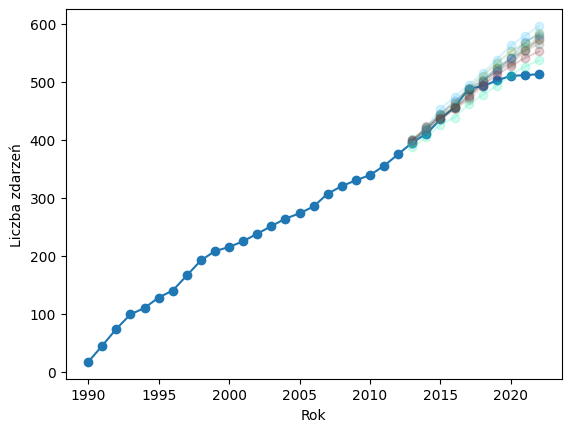

In [38]:
plt.plot(np.cumsum(pd.Series(np.concatenate((np.asarray(n),np.asarray(n_test)),axis=0),index=range(1990,2023))), linestyle= '-',marker='o')
for i in range(10):
    random_color = (random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255,0.2)
    nhpp_pred = nhpp(musa_okumoto_int_fun,result.x,11)
    unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':2012+unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n'])
    plt.plot(np.cumsum(n)[23]+np.cumsum(n_pred), linestyle= '-',marker='o',color=random_color)
plt.xlabel("Rok")
plt.ylabel("Liczba zdarzeń")
#plt.savefig("C:\\Users\\ndzad\\Dropbox\\MINI\\Magisterka\\repo\\mgr\\Rysunki\\musa_okumoto_cum_number_10.pdf")
plt.savefig("C:\\Users\\ndzadz001\\Documents\\Mgr\\Repo\\mgr\\Rysunki\\musa_okumoto_cum_number_10.pdf")
plt.show()

Stała funkcja intensywności

In [24]:
sum_of_squares_const([1])

6380

In [25]:
bnds = ((0, None)) # ograniczenia na wartości parametrów
params = [1.0] # Przyjmujemy początkowe wartości parametrów
result = minimize(sum_of_squares_const, params, bounds=bnds, method='L-BFGS-B')
nhpp_pred = nhpp(const_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
N_pred = np.cumsum(n_pred)
print(n_pred)

TypeError: 'int' object is not iterable

Wykładnicza funkcja intensywności

In [ ]:
bnds = ((0, None), (0, None)) # ograniczenia na wartości parametrów
params = [1.0, 1.0] # Przyjmujemy początkowe wartości parametrów
result = minimize(sum_of_squares_exp, params, bounds=bnds, method='L-BFGS-B')
nhpp_pred = nhpp(exp_int_fun,result.x,11)
unique, counts = np.unique(np.ceil(nhpp_pred[1]), return_counts=True)
values = pd.DataFrame({'Year':2012+unique, 'n':counts})
index_df = pd.DataFrame({'Year':np.array(range(2013,2023))})
merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
n_pred = pd.Series(merged_table['n'])
N_pred = np.cumsum(n_pred)
print(n_pred)

Year
2013    1.0
2014    1.0
2015    0.0
2016    1.0
2017    0.0
2018    2.0
2019    1.0
2020    2.0
2021    1.0
2022    1.0
Name: n, dtype: float64


In [ ]:
print("MSE: ", MSE(n_test,n_pred), "MAE: ", MAE(n_test,n_pred))

MSE:  272.8 MAE:  12.8
